# Import necessary modules

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import librosa as lb
from scipy.signal import hamming, hanning
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

# Define some helper functions

In [2]:
def get_MFCC(y, fs, N_mel):
    """
    Calculate MFCCs for each audio signal
    :return MFCCs: MFCC of the audio
    """

    # Using short window length, 20 ms is typical value for speec audio 
    win_len = int(0.02*fs)
    # Using Hamming window function to have better visibility of spectral peaks and reduce spectral smearing, 
    # set sym to False since we are doing spectraL analysis
    hamming_win = hamming(win_len, sym=False) 
    # Common hop size in windowing process, 50% overlap-added
    hop_len = win_len//2                        
    # Number of DFT points, equal to window length
    n_fft = win_len  

    # Additional keyword arguments to librosa.feature.melspectrogram
    kwarg_melspec = {'win_length': win_len, 'hop_length': hop_len, 'n_fft': n_fft, 'window': hamming_win}
    MFCCs = lb.feature.mfcc(y=y, sr=fs, n_mfcc=N_mel, norm='ortho', **kwarg_melspec)   
    return MFCCs

def get_feature_matrix(data_dir, list_file):
    """
    Return statistic of all audios
    :return feature_matrix: array with shape [n_audios, 2*n_MFCCs]

    Ex: With 100 audio files, and 40 Mel bands co-efficients, for each audio file, we calculate 40 mean and 
    40 standard deviation values of 40 co-efficients over the time axis and stack them over. 
    """

    feature_matrix = []
    with zipfile.ZipFile(data_dir, "r") as unzipped_file:
        for audio_file in list_file:
            with unzipped_file.open(audio_file) as binary_file:
                # Load data
                audio, fs = lb.load(binary_file, sr=None)
                alpha = 0.97    # Co-efficient of pre-emphasis filter
                pre_emphasized_audio = np.append(audio[0], audio[1:] - alpha * audio[:-1]) 
                # Number of Mel bands to generate  
                N_mel = 40 
                MFCCs = get_MFCC(pre_emphasized_audio, fs, N_mel)

                mfcc_mean = np.mean(MFCCs, axis=1, keepdims=False)
                mfcc_std = np.std(MFCCs, axis=1, keepdims=False)
                feature_vector = np.concatenate((mfcc_mean, mfcc_std), axis=0) 
                feature_matrix.append(feature_vector)

    feature_matrix = np.array(feature_matrix)
    return feature_matrix

def get_classes_dict(label_series):
    """
    Return class names with corresponding file index  
    classes: dictionary with key is label and value is list of file index 
    """
    
    classes = {}
    for index, labels in enumerate(label_series):
        for label in labels.split(","):
            if label not in classes:
                classes[label] = []
            classes[label].append(index)

    return classes


def extract_data_from_csv(zip_data_dir, label_file):
    """
    Return MFCC of audio files and dictionary of labels with corresponding files 
    :return feature_matrix: return value from function get_feature_matrix(data_dir, list_file)
    :return class_dict: return value from function get_classes_dict(label_series)
    """
    
    label_df = pd.read_csv(label_file, delimiter=',', index_col=False, dtype={'fileName':'str', 'tags': 'str'})
    label_df.dropna(axis=0, how='any', inplace=True) 

    list_audio = label_df['fileName'].apply(lambda file_name: file_name.replace('mp3', 'wav'))           
    feature_matrix = get_feature_matrix(zip_data_dir, list_audio)                              

    label_series = label_df['tags'].apply(lambda file_name: file_name.replace('_', ' '))   
    class_dict = get_classes_dict(label_series)

    return feature_matrix, class_dict
            
    
def get_similarity_matrix(feature_matrix, color_map='BuPu'):
    """
    Return and plot the similarity matrix between each file
    :return S: similarity matrix, array with shape [n_audios, n_audios] 
    """

    S = cosine_similarity(feature_matrix)

    # Plot heatmap
    plt.style.use('default')
    plt.figure(figsize=(15, 14))
    sns.heatmap(S, cmap=color_map)
    plt.title("Cosine similarity matrix")
    plt.savefig("heat_map.png")
    plt.show()

    return S


def similarity_by_class(S, classes, plot=True):
    """
    Retrn and plot the average similartiy on each class
    :return similarity: dictionary with keys are classes 
    and values are corresponding average similartiy
    """

    similarity = {}
    sim_values = []
    for label in classes:
        list_data = classes[label]
        sum_sim = []
        for idx in range(len(list_data)):
            for id_compare in range(1, len(list_data) - idx):
                sum_sim.append(S[list_data[idx], list_data[idx + id_compare]])

        sum_sim = np.array(sum_sim)
        sim_values.append(sum_sim)
        similarity[label] = np.mean(sum_sim)
    
    # Plot box plot for similarities values per class
    if plot:
        plt.style.use('ggplot')
        plt.figure(figsize=(11, 10))
        red_diamond = dict(markerfacecolor='r', marker='D')
        bp = plt.boxplot(sim_values, showmeans=True, meanprops=red_diamond, sym='k.')
        locs = np.arange(len(classes)) + 1      # Adjust label locations
        plt.xticks(locs, classes, rotation=-45)
        plt.ylabel("Similarities")
        plt.legend([bp['medians'][0], bp['means'][0]], ['median', 'mean'])
        plt.title("Similarity between each file in each class")
        plt.tight_layout() 
        plt.savefig("similarity_on_each_classes.png")
        plt.show()

    return similarity

# Load and extract data

In [3]:
audio_file = "audio_files.zip"
label_file = "label.csv"
F, label_dict = extract_data_from_csv(audio_file, label_file)

# Audio analysis
### Get number of files that are annotated with and theirs number of files

In [4]:
label_df = pd.read_csv(label_file, delimiter=',', index_col=False)
tags = np.zeros(len(label_df))
for i, tag in enumerate(label_df['tags']):
    try:
        tags[i] = len(tag.split(','))
    except AttributeError:      # Handle 'nan' value 
        tags[i] = 0

# Count frequency of unique values
unique, counts = np.unique(tags, return_counts=True)
print("Numbers of files are annotated with:")
for uni, c in zip(unique, counts):
     print(f"{int(uni)} classes is {c}.")

# Average number of classes per audio
avg_tot_tags = np.mean(tags)
print(f"\nOn average, there are {avg_tot_tags:.1f} classes annotated on each audio.")

Numbers of files are annotated with:
0 classes is 8.
1 classes is 66.
2 classes is 45.
3 classes is 12.

On average, there are 1.5 classes annotated on each audio.


### Get number of audio files per class

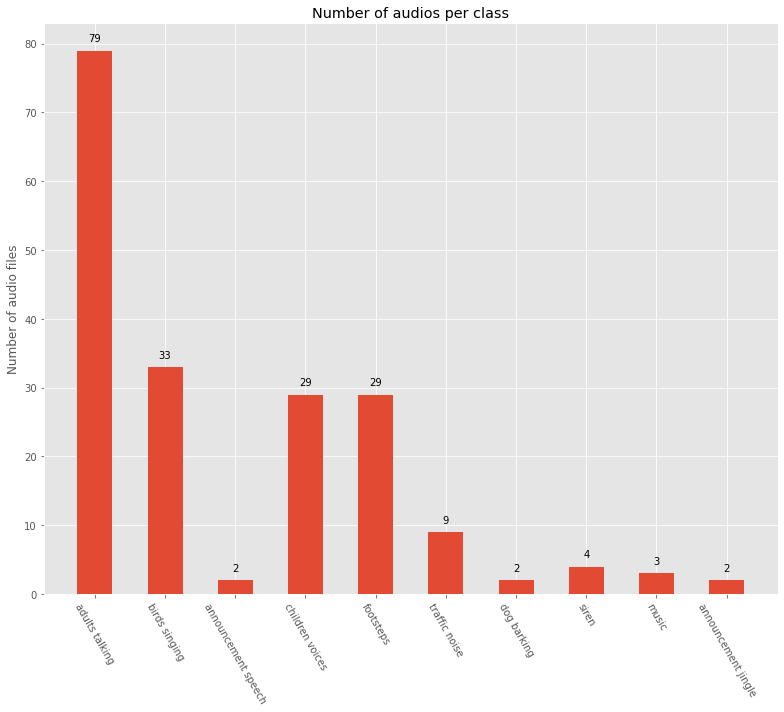

In [5]:
freq = {}
for label in label_dict:
    list_data = label_dict[label]
    freq[label] = len(list_data)
    
    x_label = tuple(freq.keys())
    value = tuple(freq.values())

# Plot 
plt.style.use('ggplot')
plt.figure(figsize=(11, 10))
plt.bar(x=x_label, height=value, width=0.5, align='center')
    
# Annotating the bar plot with the corresponding values
for i in range(len(value)):
    plt.annotate(value[i], (i, value[i] + 1), ha='center', va='bottom')

locs = np.arange(len(x_label))  # Label locations
plt.xticks(rotation=-60)
plt.ylabel("Number of audio files")
plt.title("Number of audios per class")
plt.tight_layout()
plt.savefig("audio_per_class.png")
plt.show()

### Get heatmap of similarity between files

**Note:** Cosine similarity is used to calculate similarity, so the closer the similarity value between files to 1, the more similar two files are, and vice versa  

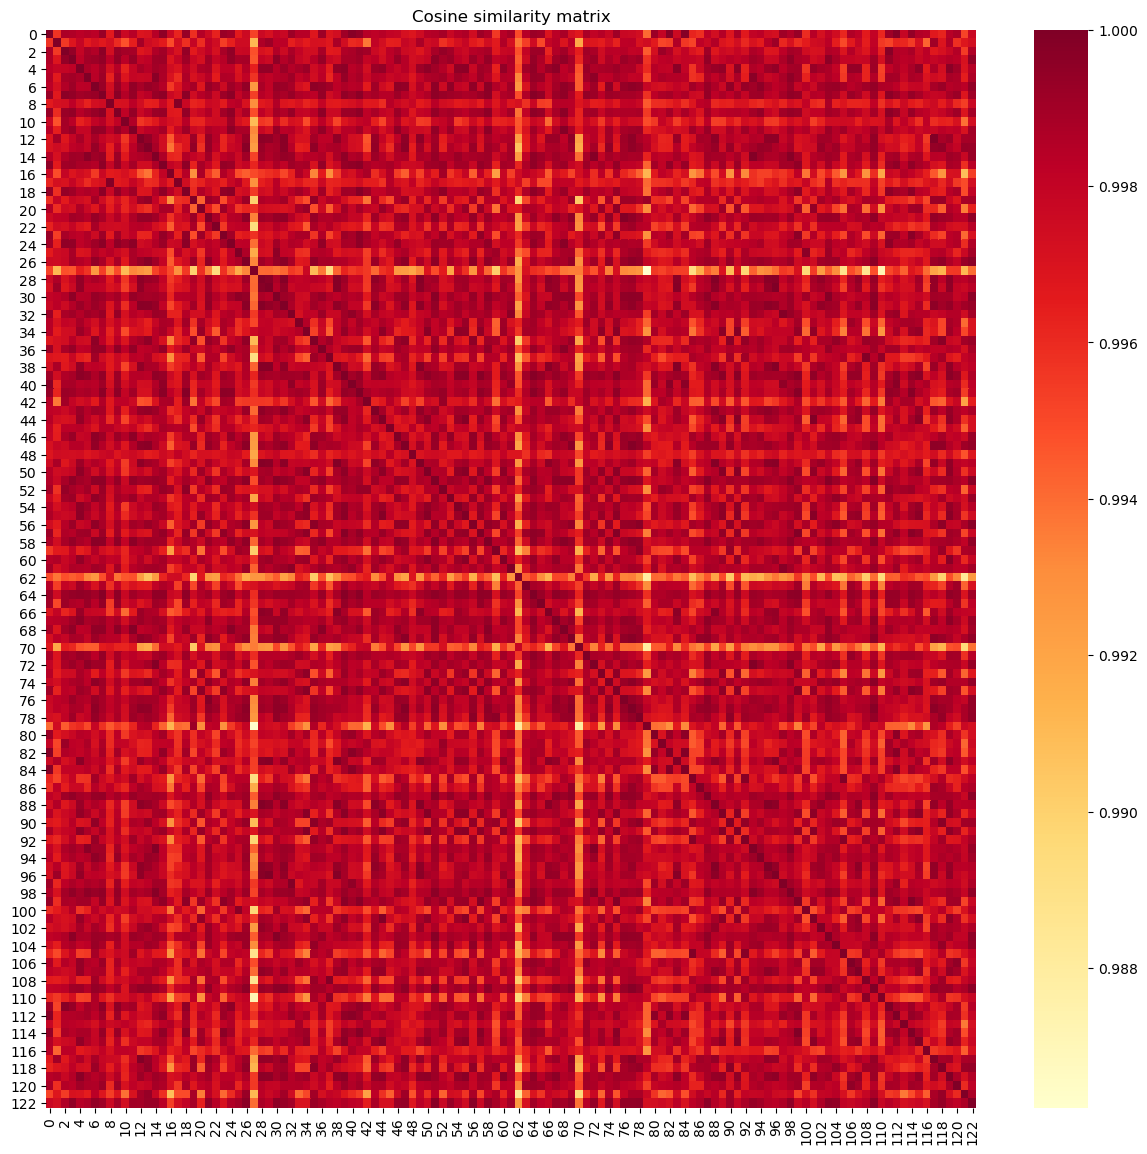

In [6]:
S = get_similarity_matrix(F, color_map='YlOrRd')

### Get similarity between each file in the same class

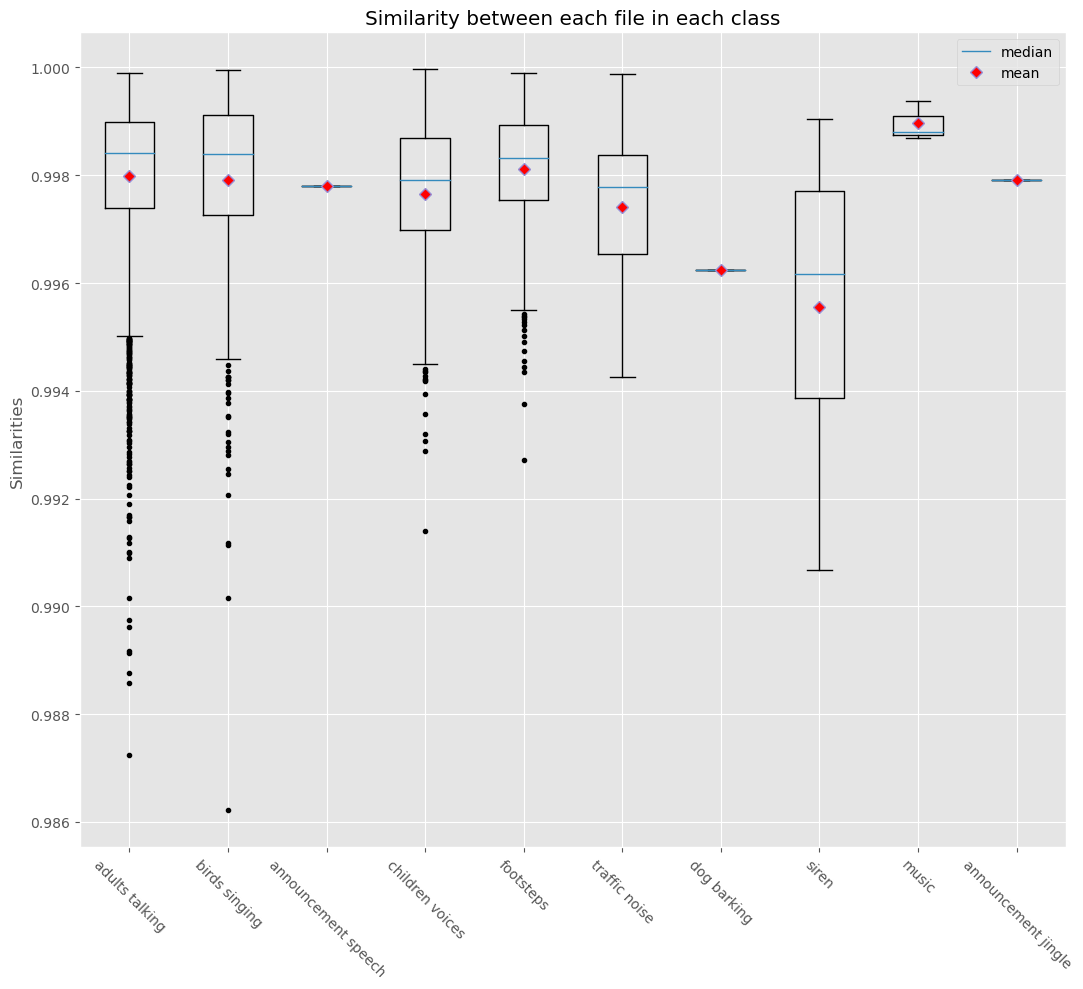

Mean values: {'adults talking': 0.9979921, 'birds singing': 0.9979054, 'announcement speech': 0.9978002, 'children voices': 0.99765843, 'footsteps': 0.9981074, 'traffic noise': 0.997406, 'dog barking': 0.99623924, 'siren': 0.99556035, 'music': 0.9989617, 'announcement jingle': 0.99791485}


In [7]:
class_similarity = similarity_by_class(S, label_dict, plot=True)
print("Mean values:", class_similarity)

### Overall similarity over all files

In [8]:
np.mean(S) - 1/len(S)  # Excluding the similarity between the file and itself

0.9895894449900805